#### The following code and solutions are submitted by Heather Passmore for the Relax Take-Home coding challange for Springboard Data Science Career Track.

## Relax Inc. Takehome Challenge
### Goal:  1) Define an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period, 2) identify which factors predict future user adoption.

### Summary of Findings:
* Engagement file has 207916 records of the date and user id of login events.
* The users file has 12000 records of user identifiers, binary variables about use, and information about user groups and which users recommended each user.
* Out of 12000 users  1322 are adopted users.
* Percentage of users who are adopted users: 11.02%
* For all catagorical variables (opted-in-to-mailing-list, enabled-for-marketing-drip, and creation-source, the number of adopted users is lower than those that have not used the service three times in a seven day stretch. See figures: 

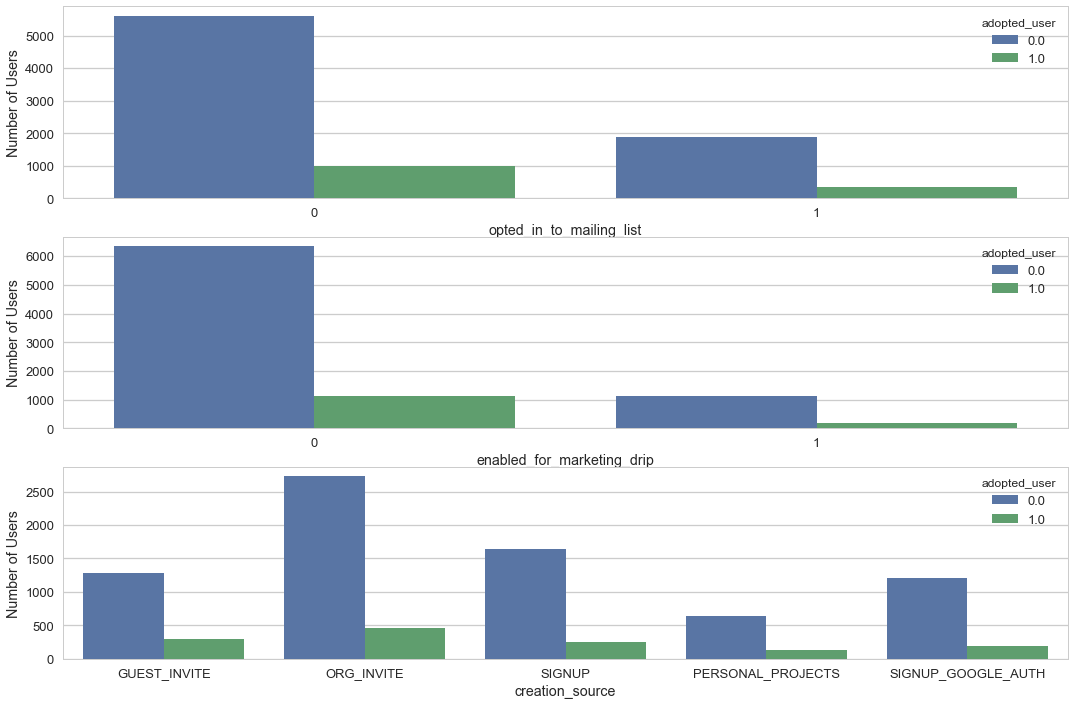

In [20]:
# Count plots of Catagorical variables with hue as adopted user

#### Classification of adopted users from user data
* My classification models were fit with:
    * binary variables opted-in-to-mailing-list enabled-for-marketing-drip
    * created binary variables 'recommender' and 'recommended' defined by the 'invited-by-user-id' field
    * Four binary variables created as dummy variables for the creation-source variable (five levels, one is dropped)
* The org-id field identifies the user group that an individual user belongs to.
    * There are 417 unique user groups
    * I fit classification models with training and testing data including 416 dummy variables created from this column.
    * Including organization ID as dummy variables did not improve the model predictive power. The org_id binary variables did not have high importance values and were not at the top of the list of features useful for predicting whether a user will become an adopted user.
    * Because adding user-id did not improve the model I removed it from the model. User-id alone (without dummy variables) is not appropriate since it is not a true continous variable.
* I compared Logistic Regression with Cross Validation and Random Forest Classifier
    * The accuracy for both models is high, but this is due to the low frequency of the positive adopted-user class.
    * The AUC-ROC score for the hyperparameter tuned Random Forest model is slightly higher than Logistic Regression. 
    * For both models the False Negative and True Negative values in the confusion matrix of the test data are zero. This may indicate that the threshold for classification could be adjusted to improve classification.
    * The feature with the highest importance is Recommender.
    * Additional influential features are: creation_source_PERSONAL_PROJECTS, opted_in_to_mailing_list, and enabled_for_marketing_drip (see below). 


Best score: 0.593739168917

Best parameters: {'max_features': 5, 'min_samples_leaf': 5, 'min_samples_split': 8}
training set score: 0.616287

test set score: 0.555517

Confusion matrix:
 [[4271    0]
 [ 529    0]]


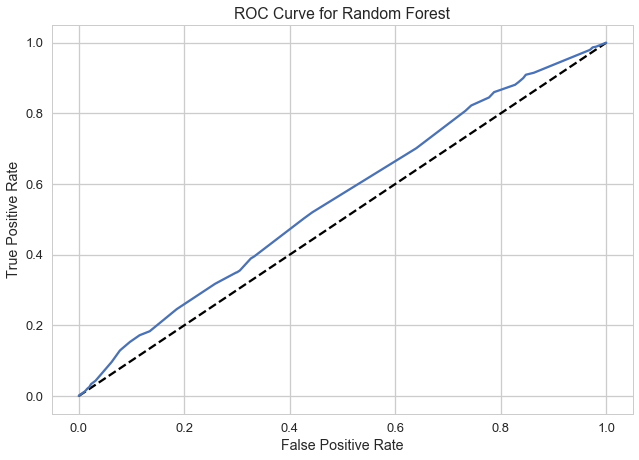

,importance
recommender,0.254266
creation_source_PERSONAL_PROJECTS,0.197902
opted_in_to_mailing_list,0.147616
enabled_for_marketing_drip,0.147511
recommended,0.085686
creation_source_ORG_INVITE,0.077836
creation_source_SIGNUP_GOOGLE_AUTH,0.052771
creation_source_SIGNUP,0.036412


In [38]:
# Random Forest Model with hyperparameter tuned with GridSearchCV

#### Recommendations and Future Directions
* One intriguing potential direction for this data set is to first examine the data using network analysis methods
    * The data include information on network connections with the user-id and invited-by-user-id fields.
    * If certain nodes of the user-network have more connections than others then those user groups could be used to increase user engagement.
    * Recommender is the most influential feature in the Random Forest Model which supports the potential utility of further exampining the connections between users and recommenders.
* If there are other available variables in the Relax records that could be added to the model they may improve our ability to predict adopted users.
* Relax could consider performing an A/B test to figure out other ways to increase user logins over time.
* There is a lot of information in the user-id variable and there is likely a useful way to include it in the model.
* Additional classification algorithms such as Decision Trees, SVM, or Multinomial Naive Bayes should also be compared.

### Code for Relax Takehome Challenge

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from datetime import datetime

In [2]:
# Read the CSV files and make DataFrames
engage_file = 'takehome_user_engagement.csv'
user_file = 'takehome_users.csv'

engagement = pd.DataFrame(pd.read_csv(engage_file, parse_dates=True))
users = pd.DataFrame(pd.read_csv(user_file, parse_dates=True, encoding = 'latin1'))

In [3]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
engagement.visited.value_counts()

1    207917
Name: visited, dtype: int64

In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [6]:
# Convert time_stamp to datetime format
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])

In [7]:
# Create 'YYMMDD' column from time_stamp with only Year Month Day, drop 'visited' & 'time_stamp'
engagement['YYMMDD'] = engagement['time_stamp'].dt.date
engagement.drop(['visited','time_stamp'], axis=1, inplace=True)

In [8]:
engagement.shape

(207917, 2)

### Define Adopted User
#### Code as '1' users who  logged into the product on 3 separate days in at least one seven-day period, else '0'

In [9]:
# drop duplicates in new 'engagement' dataframe: we are interested in counting login-days not logins per day
engagement.drop_duplicates(inplace=True)
engagement.shape
# There are no identical rows of user and date

(207917, 2)

In [10]:
# define a function to identify users who logged in three times in any 7-day period
from datetime import datetime, timedelta

def adopted(a):
    if len(a) >= 3:  
        a = [i for i in a]  # convert property object to list
        a.sort()
        a = [a[i+1] - a[i] for i in range(len(a)-2)]  # cumulative difference of current and next day
        a = [1 for i in range(len(a)-2) if a[i] + a[i+1] + a[i+2] <= timedelta(days=7)]
        if 1 in a:
            return 1

In [11]:
# group by user_id and aggregate using custom function 'adopted'
adopt = engagement.groupby('user_id').agg(adopted)  
# fill null values with 0
adopt.fillna(0, inplace=True)
adopt.columns = ['adopted_user']
adopt.head()

,adopted_user
user_id,
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0


In [12]:
print('Out of 12000 users ', len(adopt[adopt['adopted_user']==1]),'are adopted users.')
print('\nPercentage of users who are adopted users:', round(1322/12000*100,2),'%')

Out of 12000 users  1322 are adopted users.

Percentage of users who are adopted users: 11.02 %


### Join 'users' with 'adopt' on the 'adopt' index to add 'adopted_user' column

In [13]:
df = users.join(adopt, on='object_id')
df.tail()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0,0.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN,0.0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0,0.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN,0.0
11999,12000,2014-01-26 08:57:12,Lima Thaís,ThaisMeloLima@hotmail.com,SIGNUP,1.390727e+09,0,1,0,NaN,0.0


In [14]:
# One forth of users subscribe to mailing list
df.opted_in_to_mailing_list.value_counts()

0    9006
1    2994
Name: opted_in_to_mailing_list, dtype: int64

In [15]:
# 16% of users are enabled for marketing drip
df.enabled_for_marketing_drip.value_counts()

0    10208
1     1792
Name: enabled_for_marketing_drip, dtype: int64

In [16]:
df.groupby(['opted_in_to_mailing_list', 'adopted_user']).size()

opted_in_to_mailing_list  adopted_user
0                         0.0             5618
                          1.0              979
1                         0.0             1883
                          1.0              343
dtype: int64

In [17]:
df.groupby(['enabled_for_marketing_drip', 'adopted_user']).size()

enabled_for_marketing_drip  adopted_user
0                           0.0             6360
                            1.0             1122
1                           0.0             1141
                            1.0              200
dtype: int64

In [18]:
df.adopted_user.value_counts()

0.0    7501
1.0    1322
Name: adopted_user, dtype: int64

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Figures inline, visualization style
%matplotlib inline

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("talk")

In [20]:
df = users.join(adopt, on='object_id')
df.tail()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0,0.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN,0.0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0,0.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN,0.0
11999,12000,2014-01-26 08:57:12,Lima Thaís,ThaisMeloLima@hotmail.com,SIGNUP,1.390727e+09,0,1,0,NaN,0.0


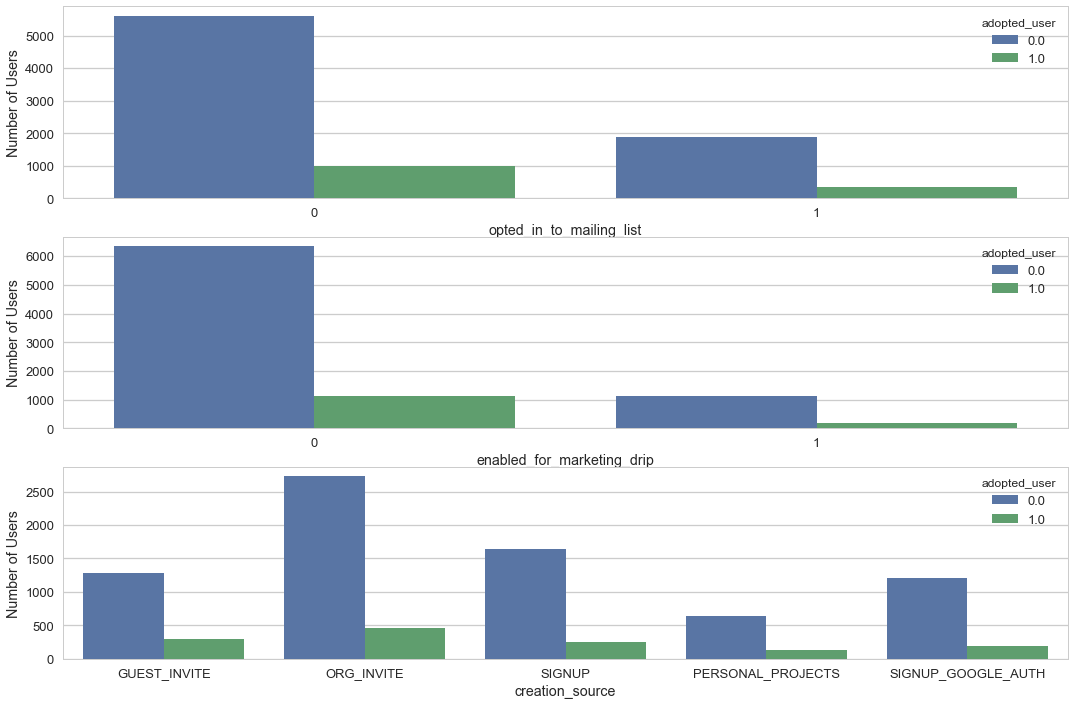

In [21]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Explore data for adopted vs not adopted users
fig, ax=plt.subplots(3,1)
fig.set_size_inches(18,12)

sns.countplot(x='opted_in_to_mailing_list', data=df, ax=ax[0], hue='adopted_user')
sns.countplot(x='enabled_for_marketing_drip', data= df, ax=ax[1], hue='adopted_user')
sns.countplot(x='creation_source', data=df, ax=ax[2], hue='adopted_user')


ax[0].set_ylabel('Number of Users')
ax[1].set_ylabel('Number of Users')
ax[2].set_ylabel('Number of Users')

In [22]:
df.invited_by_user_id.describe()

count     6417.000000
mean      5962.957145
std       3383.761968
min          3.000000
25%       3058.000000
50%       5954.000000
75%       8817.000000
max      11999.000000
Name: invited_by_user_id, dtype: float64

In [23]:
# Create a list of inviter user ids
recommend_set = list(df['invited_by_user_id'].unique()) 
print(len(recommend_set))

2565


In [24]:
# Identify which users are recommender=1, not recommender=0.
df['recommender'] = 0
df['object_id2'] = df['object_id'] * 1.0
df['rec'] = np.isin(df['object_id2'], recommend_set)

df.loc[df['rec'] == False, 'recommender'] = 0
df.loc[df['rec'] == True, 'recommender'] = 1


df['recommender'].sum()

2564

In [25]:
# Create column of users who were recommened=1, not recommended=0
df['recommended'] = 0
df.loc[df['invited_by_user_id'] > 0, 'recommended'] = 1

In [26]:
df['recommended'].sum()

6417

In [27]:
# create dummies for catagorical fields
df_ml = pd.get_dummies(data=df, columns=['creation_source'], drop_first = True)
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 18 columns):
object_id                             12000 non-null int64
creation_time                         12000 non-null object
name                                  12000 non-null object
email                                 12000 non-null object
last_session_creation_time            8823 non-null float64
opted_in_to_mailing_list              12000 non-null int64
enabled_for_marketing_drip            12000 non-null int64
org_id                                12000 non-null int64
invited_by_user_id                    6417 non-null float64
adopted_user                          8823 non-null float64
recommender                           12000 non-null int64
object_id2                            12000 non-null float64
rec                                   12000 non-null bool
recommended                           12000 non-null int64
creation_source_ORG_INVITE            12000 non-null uint8

In [28]:
# Fill NaN adopted_users as '0'
df_ml[['adopted_user', 'last_session_creation_time']] = df_ml[['adopted_user', 'last_session_creation_time']].fillna(value=0)

In [29]:
df_ml.adopted_user.value_counts()

0.0    10678
1.0     1322
Name: adopted_user, dtype: int64

### Import classifiers and split training and testing data

In [30]:
# Import scikit-learn tools, grid search cross validation, and classifiers
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# import Logistic Regression CV Classifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn import decomposition
from sklearn.preprocessing import MinMaxScaler

In [31]:
X = df_ml.drop(['object_id', 'creation_time', 'name', 'email', 'org_id', 'last_session_creation_time', 'invited_by_user_id',
               'adopted_user', 'object_id2', 'rec'], axis=1) 
y = df_ml.adopted_user.values

In [32]:
X.shape

(12000, 8)

In [33]:
# Train Test Split
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=7, stratify=y)

# Show the results of the split
print("X Training set sample size:", (X_train.shape[0]))
print("X Testing set sample size:", (X_test.shape[0]))
print("y Training set sample size:", (y_train.shape[0]))
print("y Testing set sample size:", (y_test.shape[0]))

X Training set sample size: 7200
X Testing set sample size: 4800
y Training set sample size: 7200
y Testing set sample size: 4800


In [34]:
# Double check stratification
print(np.mean(y_train == 0))
print(np.mean(y_test == 0))

0.889861111111
0.889791666667


### Logistic Regression CV

training set score: 0.889861

test set score: 0.889792

Confusion Matrix:
 [[4271    0]
 [ 529    0]]


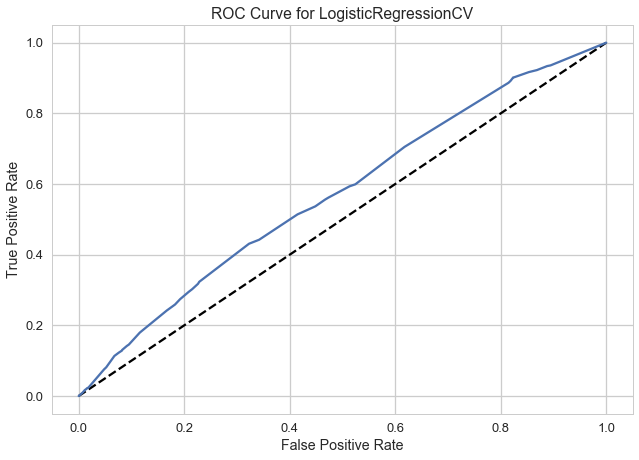


AUC score: 0.571123269919

parameters of current Logistic Regression CV model
 LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring='roc_auc', solver='lbfgs', tol=0.0001,
           verbose=0)


In [35]:
# Fit Logistic Regression with Cross Validation
lgr=LogisticRegressionCV(scoring='roc_auc').fit(X_train,y_train)
print("training set score: %f" % lgr.score(X_train, y_train))
print('\n'"test set score: %f" % lgr.score(X_test, y_test))

# calculated predicted class label per sample: pred_lgr
pred_lgr = lgr.predict(X_test)

# print the confusion matrix 
print('\n''Confusion Matrix:''\n', metrics.confusion_matrix(y_test, pred_lgr))

# calculate predicted probabilities for X_test Logistic Regression model
y_pred_prob_lgr = lgr.predict_proba(X_test)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_lgr)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LogisticRegressionCV')
plt.show()

# calculate AUC for LogisticRegressionCV classifier
print('\n''AUC score:', metrics.roc_auc_score(y_test, y_pred_prob_lgr))

# view paramaters of logistic regression CV
print('\n''parameters of current Logistic Regression CV model''\n',  lgr)

### Random Forest Classifier

training set score: 0.889861

test set score: 0.889792

Confusion matrix:
 [[4271    0]
 [ 529    0]]


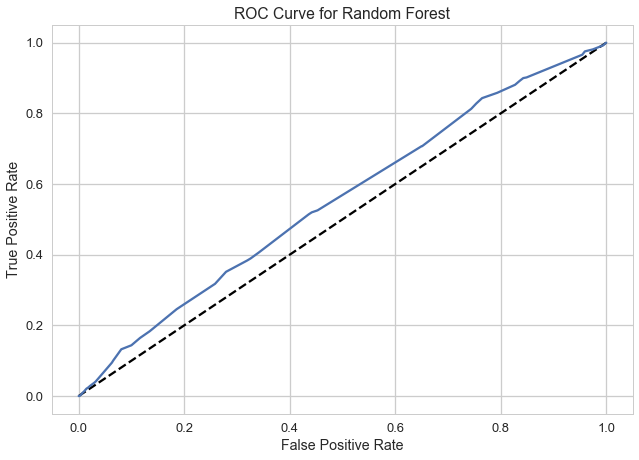

AUC Score for Random Forest Model 0.553856868253


In [36]:
# Fit the random forest model to X_train, y_train. 
rf = RandomForestClassifier().fit(X_train, y_train) 

## And score it on your testing data.
print("training set score: %f" % rf.score(X_train, y_train))
print('\n'"test set score: %f" % rf.score(X_test, y_test))

# calculated predicted class label per sample: pred_rf
pred_rf = rf.predict(X_test)

# print the confusion matrix 
print('\n''Confusion matrix:''\n', metrics.confusion_matrix(y_test, pred_rf))

# calculate predicted probabilities
y_pred_prob_rf = rf.predict_proba(X_test)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_rf)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.show()

# calculate AUC for randomforest model
print('AUC Score for Random Forest Model', metrics.roc_auc_score(y_test, y_pred_prob_rf))

In [37]:
# find best parameters with GridSearchCV
# create a list of performace parameters for performace tuning
params = {'max_features': [2,5,6,8],
              'min_samples_leaf': [3,5,7,10],
              'min_samples_split': [5, 8, 10, 12],
         }


Best score: 0.593739168917

Best parameters: {'max_features': 5, 'min_samples_leaf': 5, 'min_samples_split': 8}
training set score: 0.616287

test set score: 0.555517

Confusion matrix:
 [[4271    0]
 [ 529    0]]


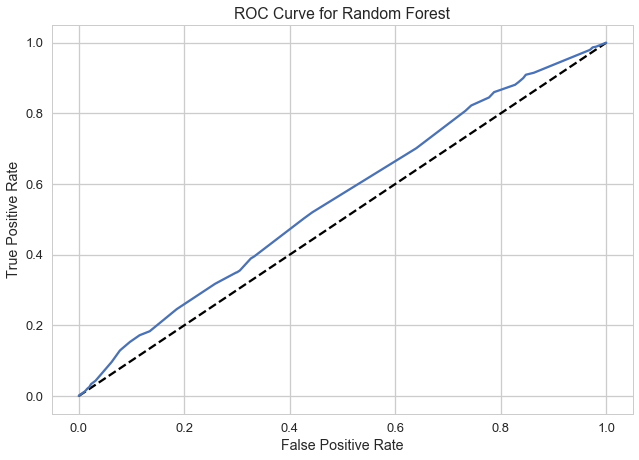

,importance
recommender,0.254266
creation_source_PERSONAL_PROJECTS,0.197902
opted_in_to_mailing_list,0.147616
enabled_for_marketing_drip,0.147511
recommended,0.085686
creation_source_ORG_INVITE,0.077836
creation_source_SIGNUP_GOOGLE_AUTH,0.052771
creation_source_SIGNUP,0.036412


In [38]:
# create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.
gs_rf = GridSearchCV(RandomForestClassifier(), params, scoring='roc_auc', n_jobs=-1)
gs_rf = gs_rf.fit(X_train, y_train) 

# View the best AUC score
print('\n''Best score:', gs_rf.best_score_) 

# Get best parameters
print('\n''Best parameters:', gs_rf.best_params_)

## And score it on your testing data.
print("training set score: %f" % gs_rf.score(X_train, y_train))
print('\n'"test set score: %f" % gs_rf.score(X_test, y_test))

# calculated predicted class label per sample: pred_rf
pred_gs_rf = gs_rf.predict(X_test)

# print the confusion matrix 
print('\n''Confusion matrix:''\n', metrics.confusion_matrix(y_test, pred_gs_rf))

# calculate predicted probabilities
y_pred_prob_gs_rf = gs_rf.predict_proba(X_test)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_gs_rf)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.show()

# Explore feature importances
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
# Print sorted list of feature importances
feature_importances